In [1]:
import numpy
import pandas
from src.data_objects import AllData
from src.functions import *

retrain = False
runchain = False

model_par = "input/fullDesign.txt"
ThisData = AllData
outdir = "/data/rjfgroup/rjf01/cameron.parker/tunes/new/"

Trimming points and obs ranges

In [2]:
trimRanges(ThisData)

In [3]:
badpoints = []
trimPoints(badpoints,ThisData)

Making Data pkl for selected observables

In [4]:
buildDataPkl(ThisData)
print(ThisData["datapkl"])

temp-pkls/data.pkl


Getting emulators

In [5]:
from src.emulator_BAND import EmulatorBAND

if retrain:
    buildObsPkls(ThisData)
    trainEmulators(model_par, ThisData)
else:
    readEmulators(ThisData)

Running Chain

In [6]:
from src.mcmc import Chain
import os

mymcmc = Chain(expdata_path=ThisData["datapkl"], model_parafile=model_par)
mymcmc.loadEmulator(getEmuPathList(ThisData))

[INFO][mcmc] Initializing MCMC ...
[INFO][mcmc] Final Markov Chain results will be saved in mcmc/chain.pkl
[INFO][mcmc] Loading the model parameters space from input/fullDesign.txt ...
[INFO][mcmc] Run MCMC with emcee...
[INFO][mcmc] Loading the experiment data from temp-pkls/data.pkl ...
[INFO][mcmc] Experimental dataset size: 391
[INFO][mcmc] Number of Emulators: 12


In [7]:
os.environ["OMP_NUM_THREADS"] = "1"
# may have to: export RDMAV_FORK_SAFE=1 before running the code

n_effective=2000
n_active=1000
n_prior=4000
sample="tpcn"
n_max_steps=100
random_state=42

n_total = 25000
n_evidence = 0

pool = 12

if runchain:
    sampler = mymcmc.run_pocoMC(n_effective=n_effective, n_active=n_active,
                            n_prior=n_prior, sample=sample,
                            n_max_steps=n_max_steps, random_state=random_state,
                            n_total=n_total, n_evidence=n_evidence, pool=pool)

Corner Plot

[WARNING][core] Too few points to create valid contours


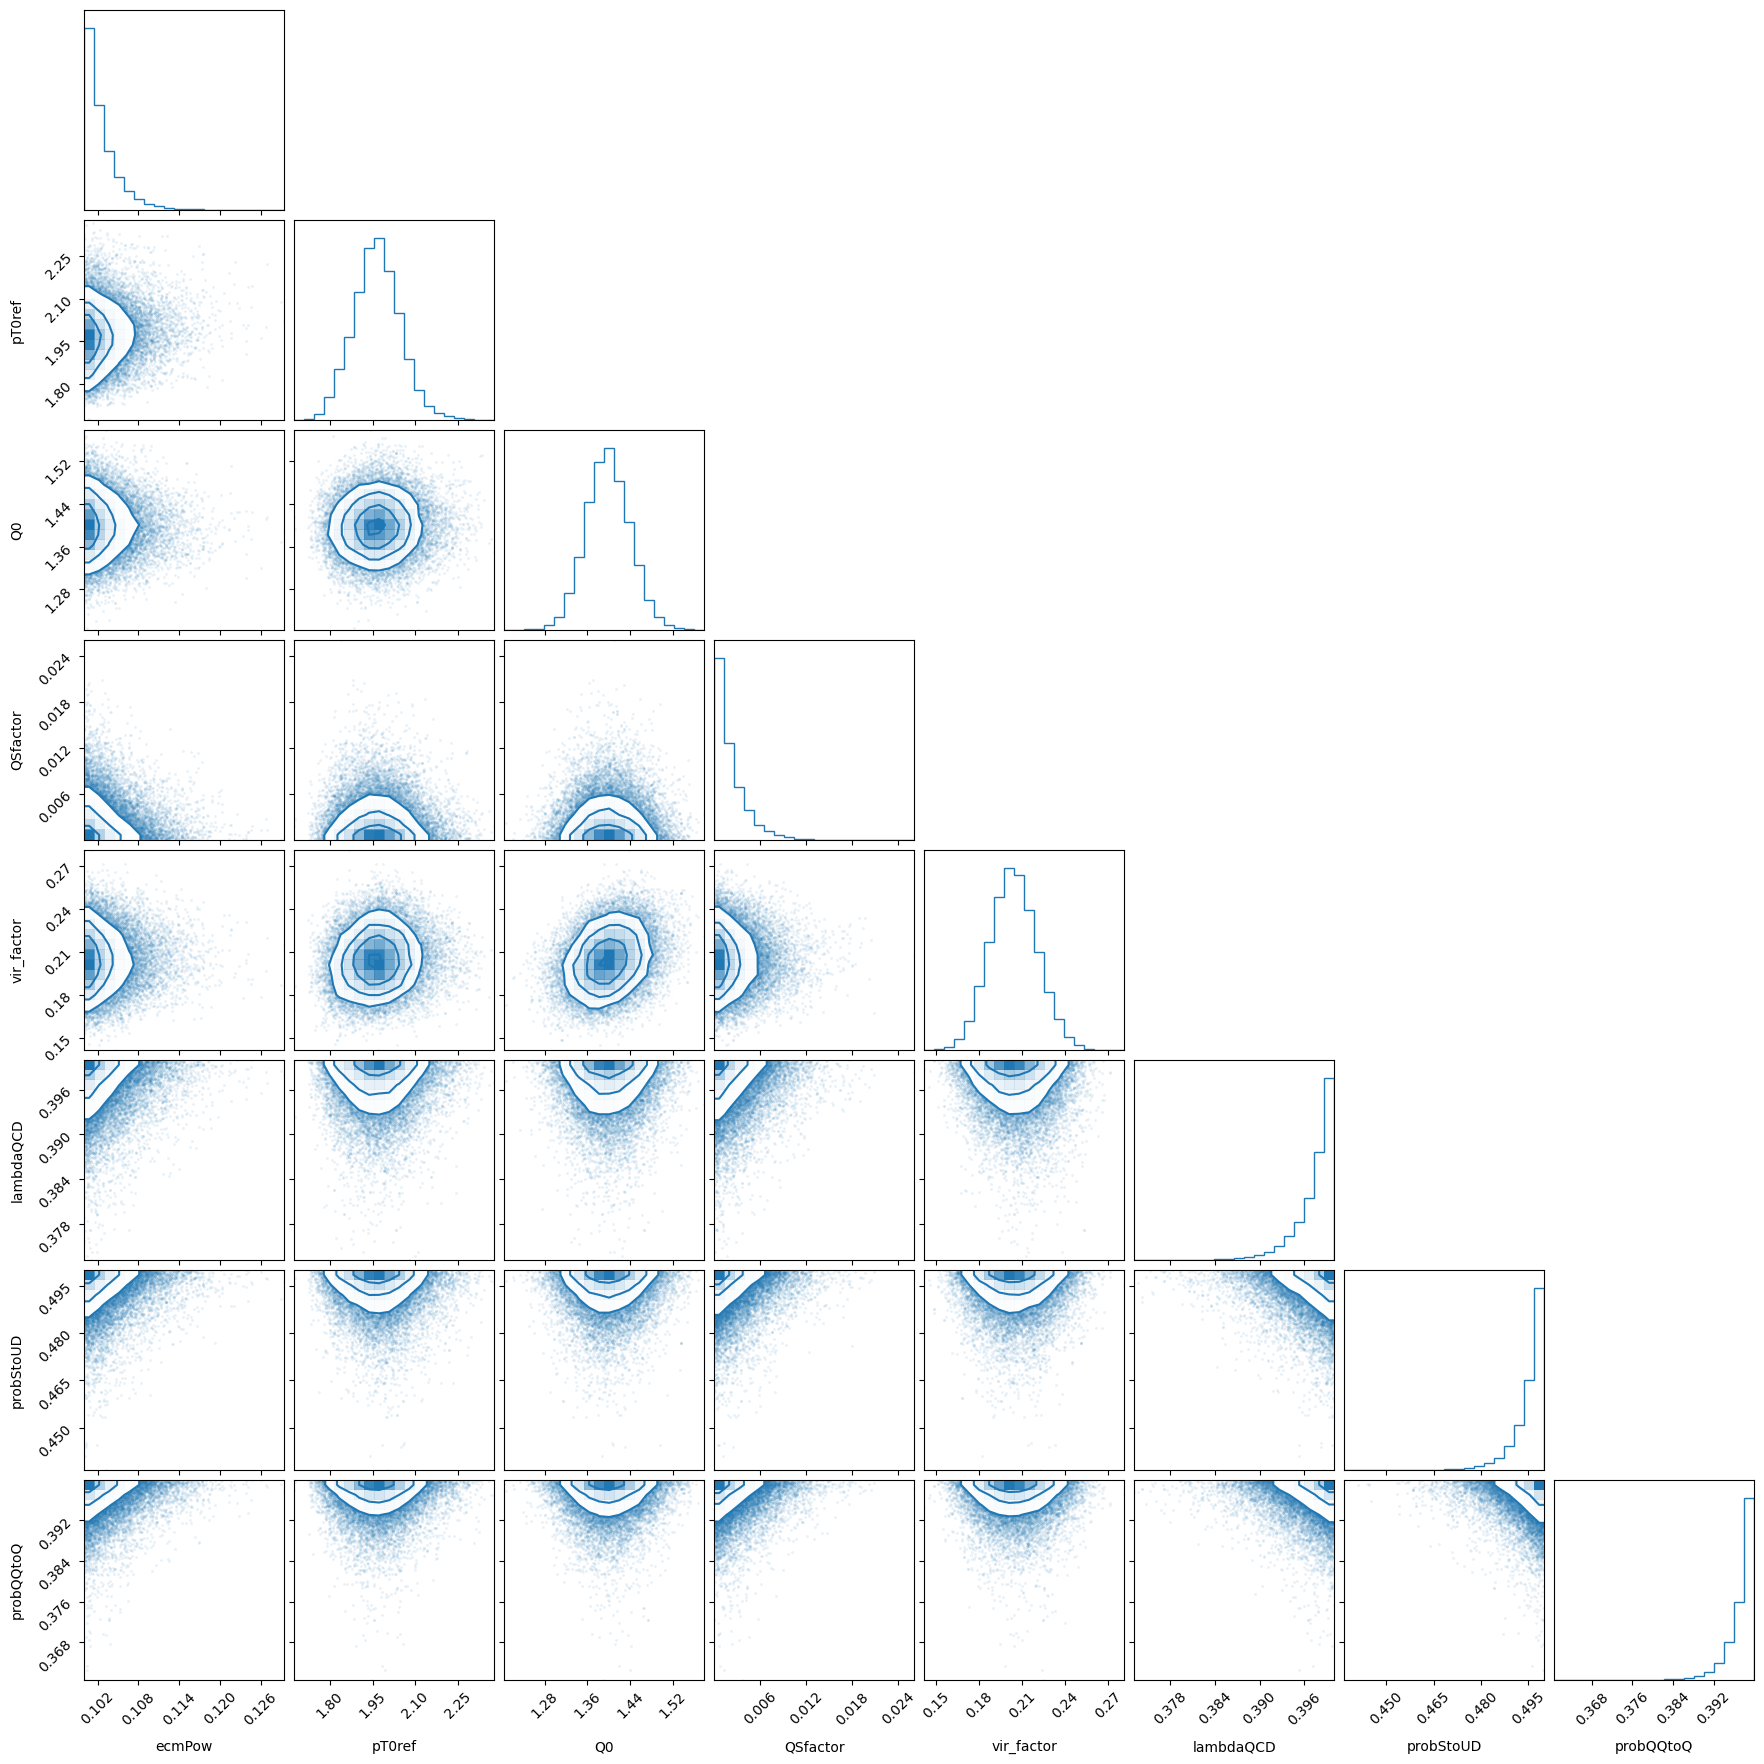

In [8]:
import pickle
import corner
import matplotlib.pyplot as plt
import numpy as np
        
with open('mcmc/chain.pkl', 'rb') as pf:
        data = pickle.load(pf)

labels = mymcmc.label

fig = corner.corner(data['chain'], weights=data['weights'], labels=labels, color="C0")
plt.show()

[WARNING][core] Too few points to create valid contours
[WARNING][core] Too few points to create valid contours


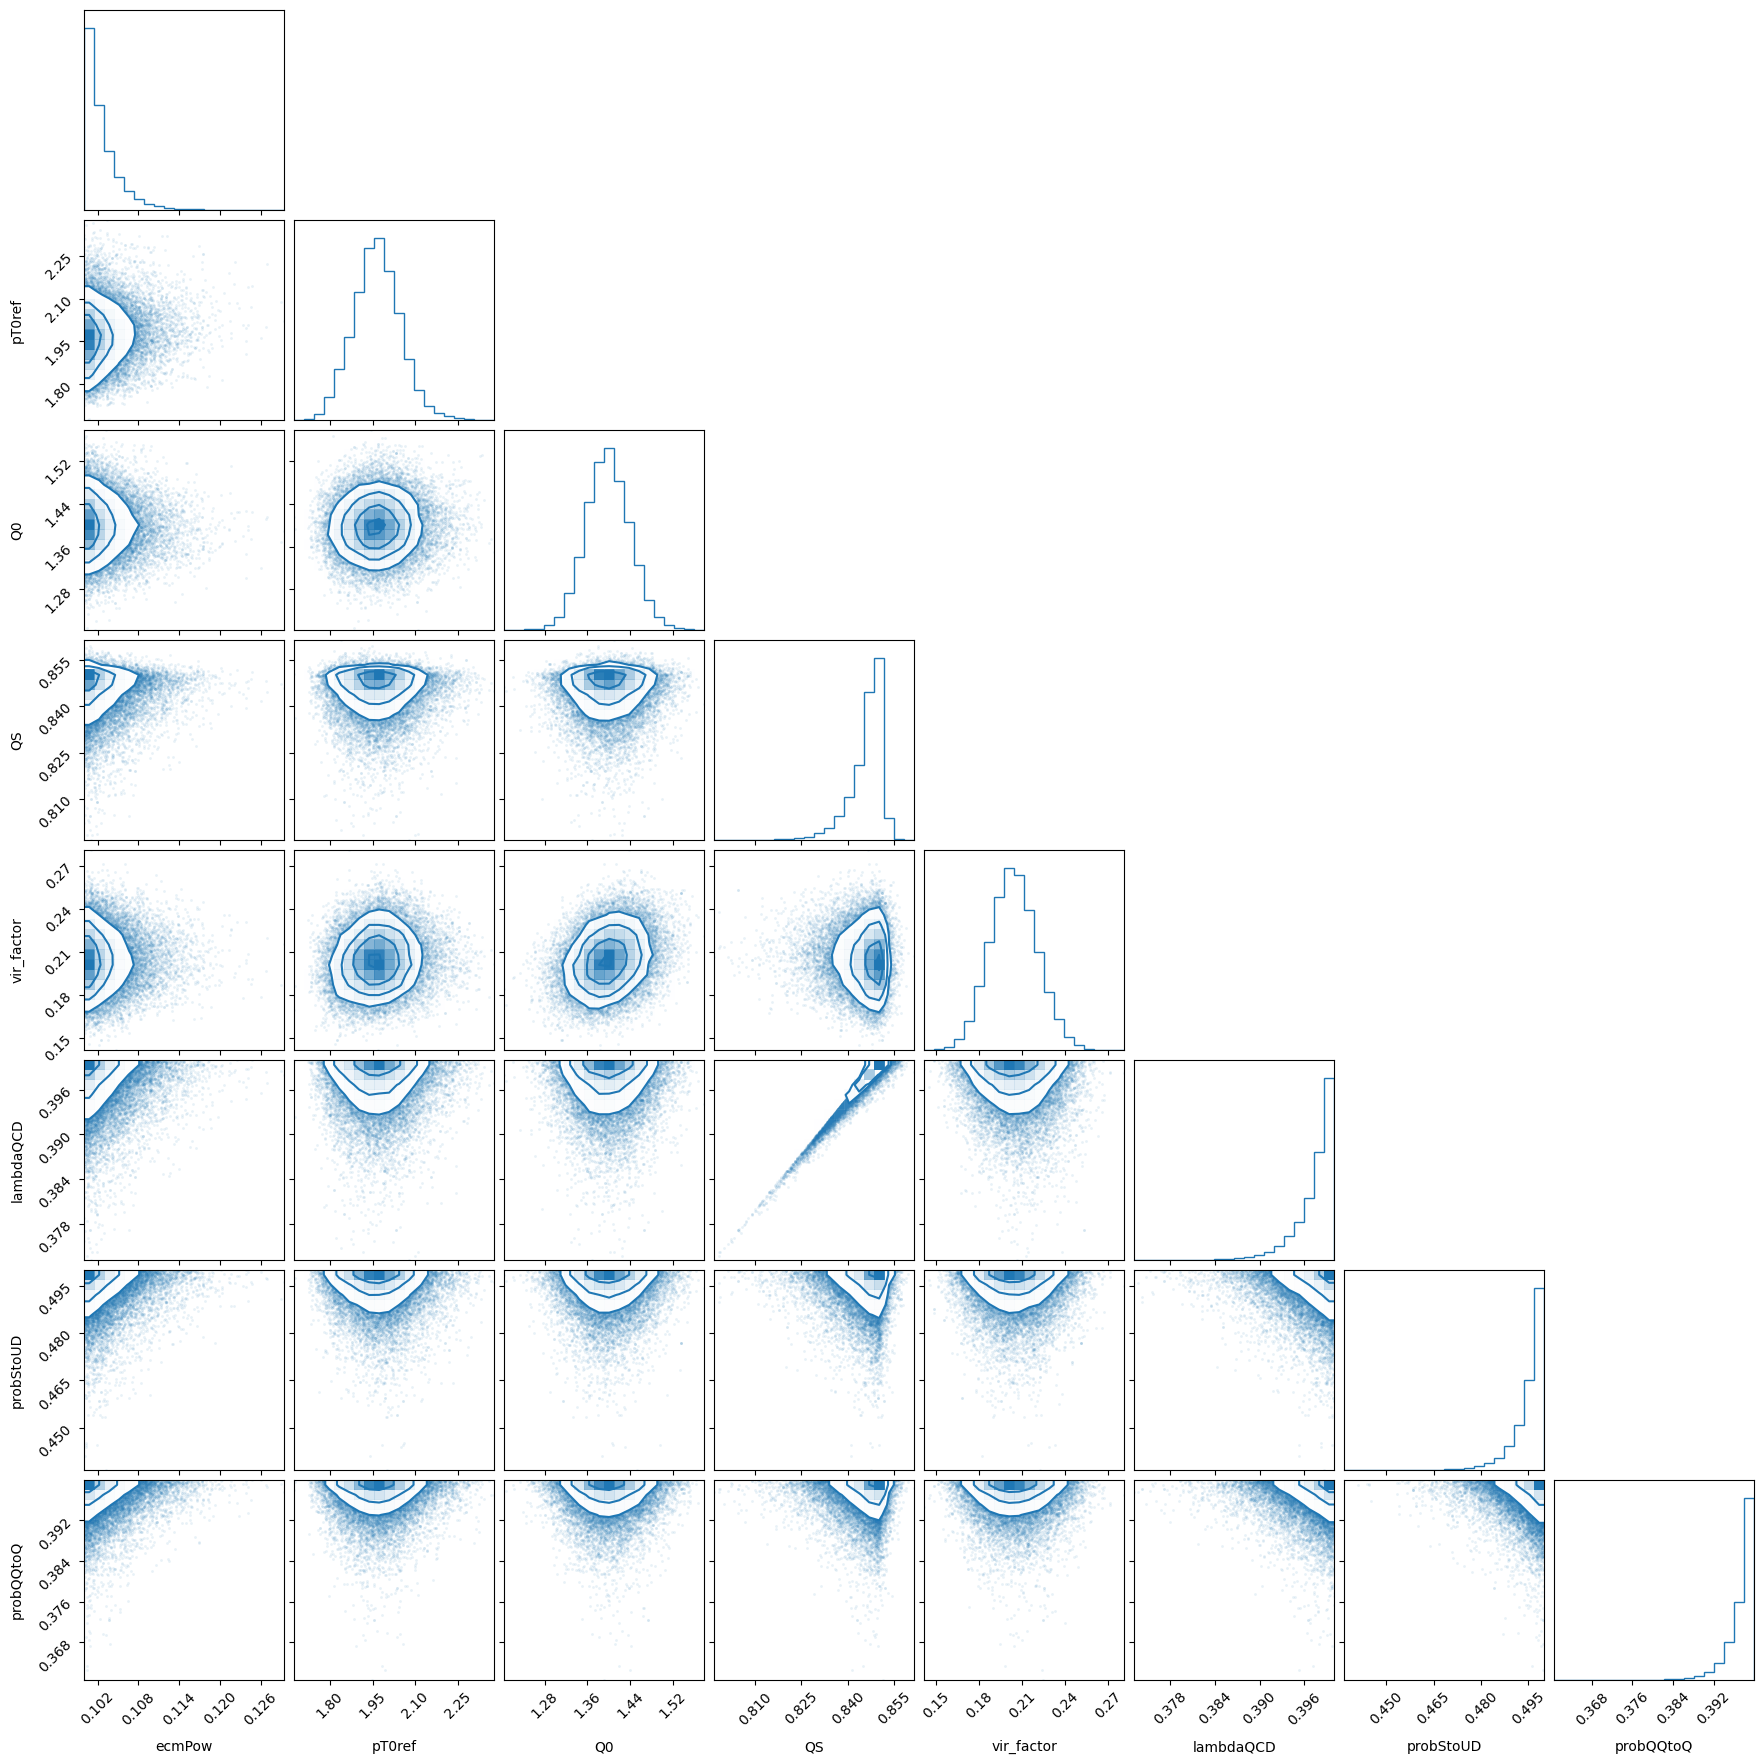

MultipartonInteractions:ecmPow: 0.102-0.002+0.007
MultipartonInteractions:pT0Ref: 1.966-0.135+0.145
Q0: 1.398-0.068+0.072
QS: 0.847-0.013+0.004
vir_factor: 0.204-0.027+0.029
lambdaQCD: 0.398-0.007+0.002
StringFlav:probStoUD: 0.497-0.013+0.003
StringFlav:probQQtoQ: 0.398-0.007+0.002


In [9]:
TransformedSamples = np.copy(data['chain'])
TransformedSamples[:,0] = data['chain'][:,0]
TransformedSamples[:,1] = data['chain'][:,1]
TransformedSamples[:,2] = data['chain'][:,2]
TransformedSamples[:,3] = (2*data['chain'][:,5]+0.05) + (data['chain'][:,2]-(2*data['chain'][:,5]+0.05))*data['chain'][:,3]
TransformedSamples[:,4] = data['chain'][:,4]
TransformedSamples[:,5] = data['chain'][:,5]
TransformedSamples[:,6] = data['chain'][:,6]
TransformedSamples[:,7] = data['chain'][:,7]

labels[3] = "QS"
fig = corner.corner(TransformedSamples, weights=data['weights'], labels=labels, color="C0")
plt.show()

bestParams = extract_parameters(TransformedSamples, ThisData["Design"]["Parameter"], outdir)

Priors

/data/rjfgroup/rjf01/cameron.parker/builds/Bayes-Tune/src/functions.py:151: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  axes[0][i].errorbar(DX, DY, yerr = DE, fmt='ro', label="Measurements", color='black')
/data/rjfgroup/rjf01/cameron.parker/builds/Bayes-Tune/src/functions.py:152: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  axes[1][i].plot(DX, 1+(DE/DY), 'b-', linestyle = '--', color='red')
/data/rjfgroup/rjf01/cameron.parker/builds/Bayes-Tune/src/functions.py:152: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  axes[1][i].plot(DX, 1+(DE/DY), 'b-', linestyle = '--', color='red')
/data/rjfgroup/rjf01/cameron.parker/builds/Bayes-Tune/src/fun

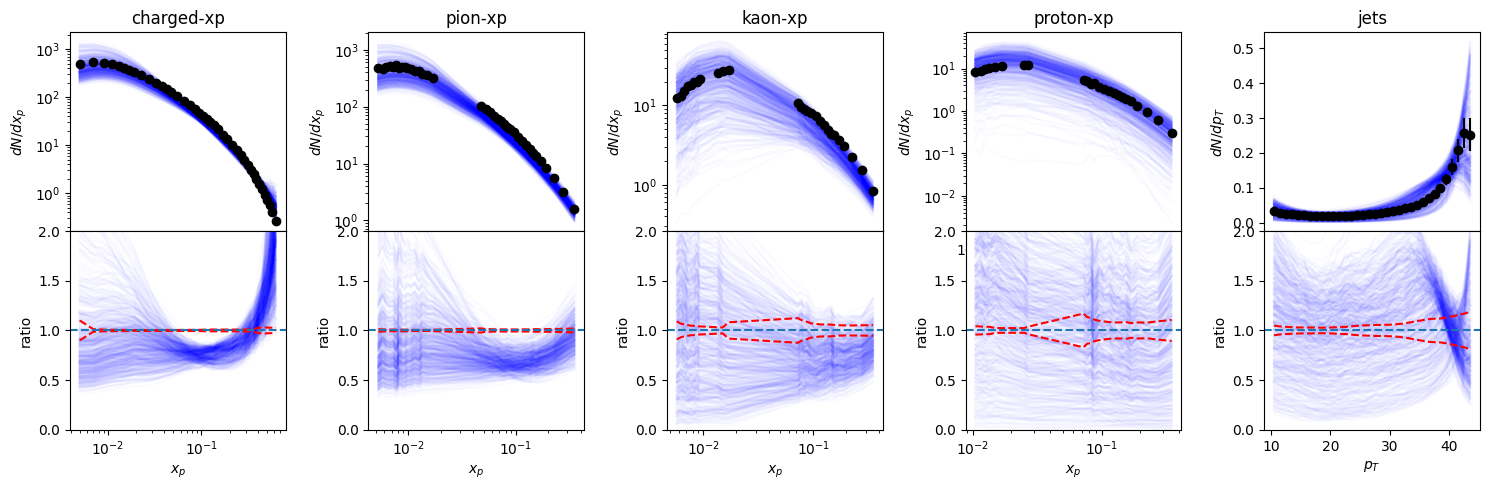

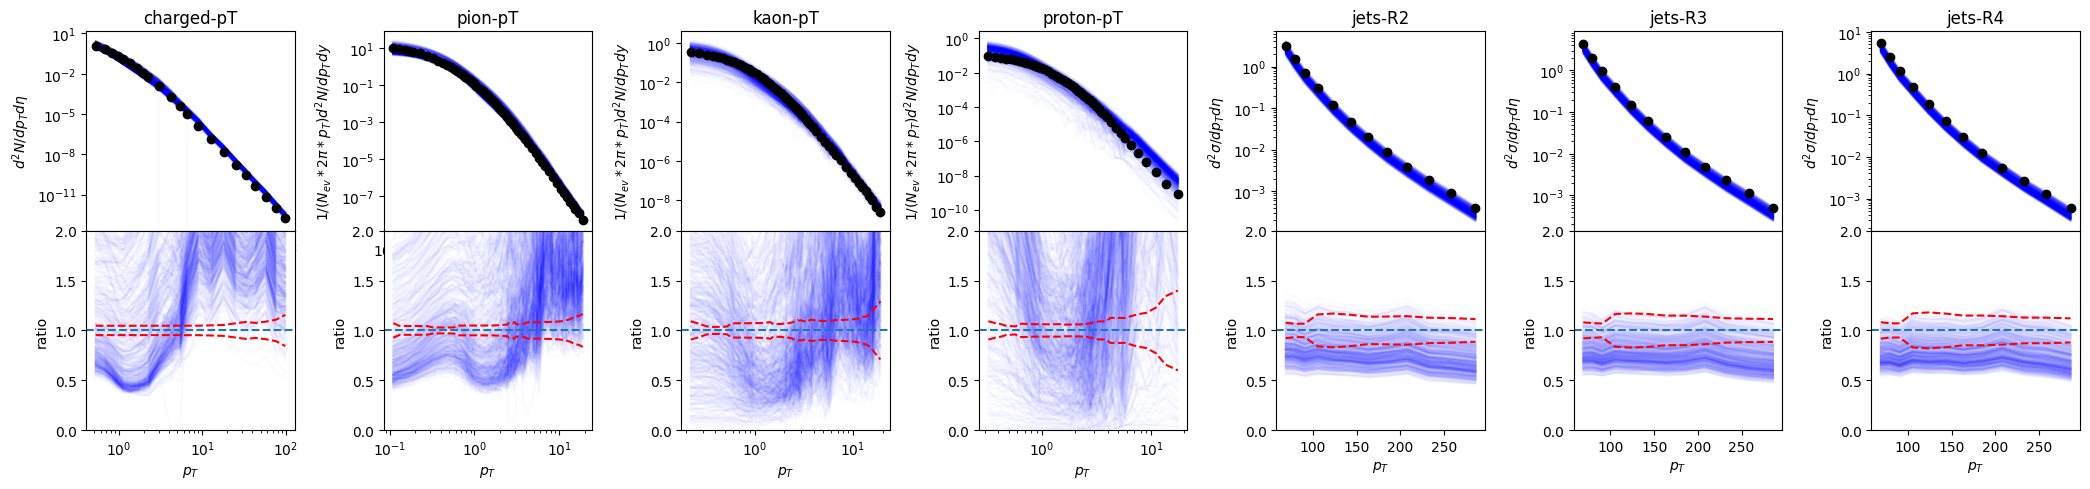

In [10]:
makeplot(ThisData, "Priors", outdir)

Posteriors

In [11]:
makeplot(ThisData, "Posteriors", outdir, samples=data["chain"])

Validation

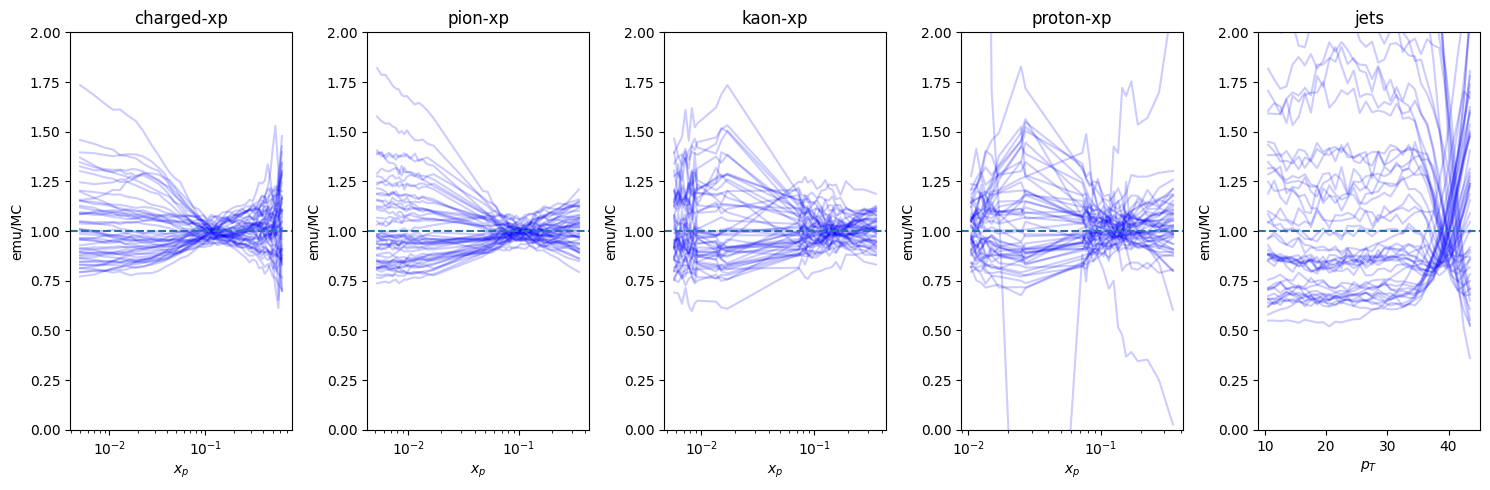

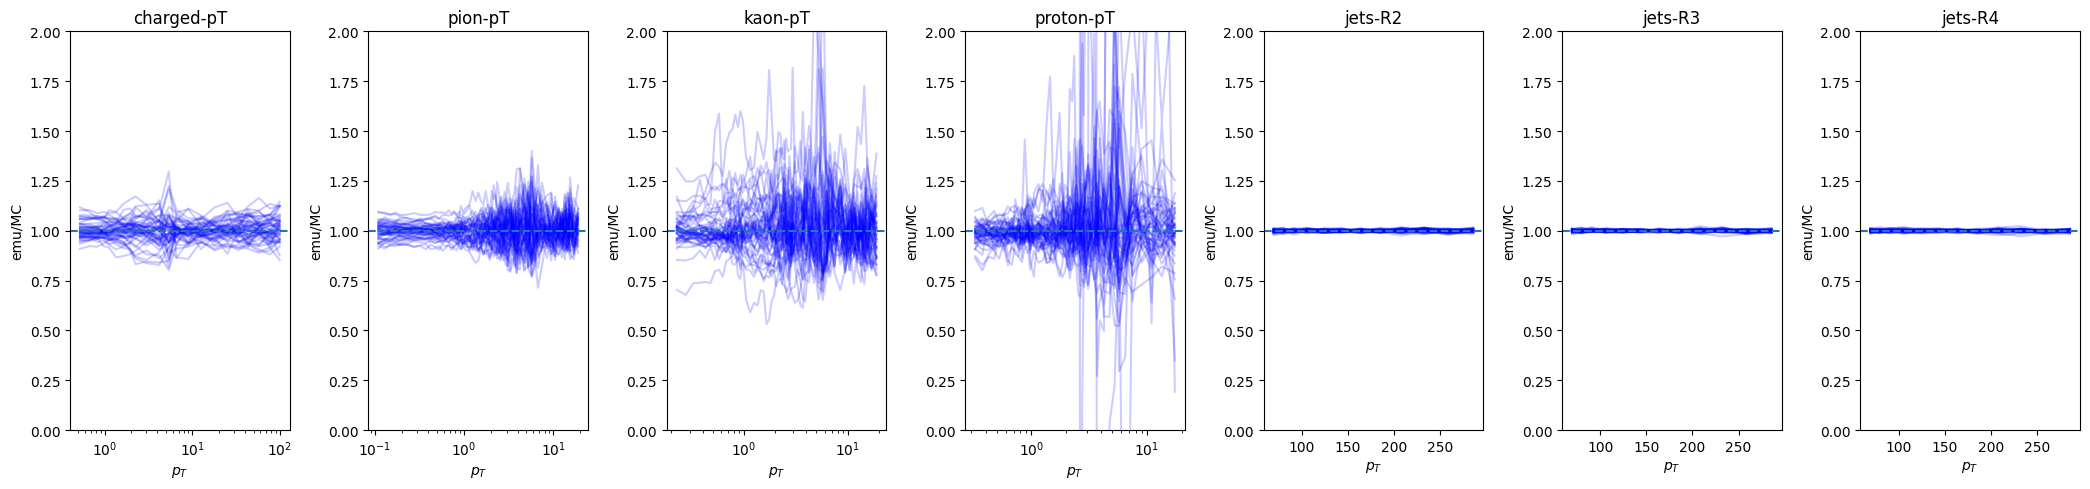

In [13]:
from src.data_objects import valData
trimRanges(valData)
validationPlots(valData, ThisData, outdir)